In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.core.pylabtools import figsize

In [136]:
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure

from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel
from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs, CheckboxButtonGroup

from bokeh.layouts import column, row, WidgetBox
from bokeh.palettes import Category20_16

from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

output_notebook()

Loading BokehJS ...

In [82]:
flights = pd.read_csv('data/flights.csv')
carriers = pd.read_csv('data/by_carrier.csv')
airlines = pd.read_csv('data/airlines.csv')

flights = flights.merge(airlines, how = 'left', on = 'carrier')

# Histogram of All Flights

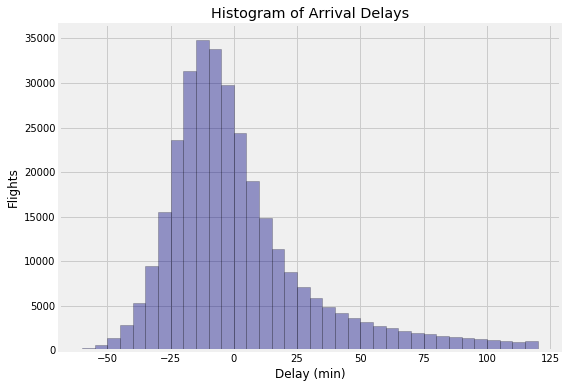

In [83]:
figsize(8, 6)
flights = flights[flights['arr_delay'].between(-60, 120)]
sns.distplot(flights['arr_delay'], hist=True, kde=False, bins=int(180/5), color = 'navy', hist_kws={'edgecolor':'black'});
plt.title('Histogram of Arrival Delays'); plt.xlabel('Delay (min)'); plt.ylabel('Flights');

# Histogram with Density Overlay

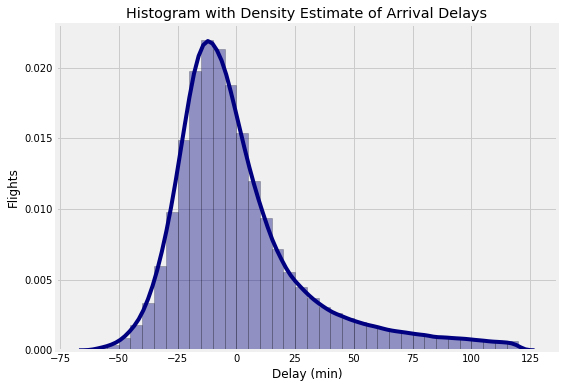

In [84]:
figsize(8, 6)
flights = flights[flights['arr_delay'].between(-60, 120)]
sns.distplot(flights['arr_delay'], hist=True, kde=True, bins=int(180/5), 
             color = 'navy', hist_kws={'edgecolor':'black'});
plt.title('Histogram with Density Estimate of Arrival Delays'); plt.xlabel('Delay (min)'); plt.ylabel('Flights');

# Density with Varying Bandwidths

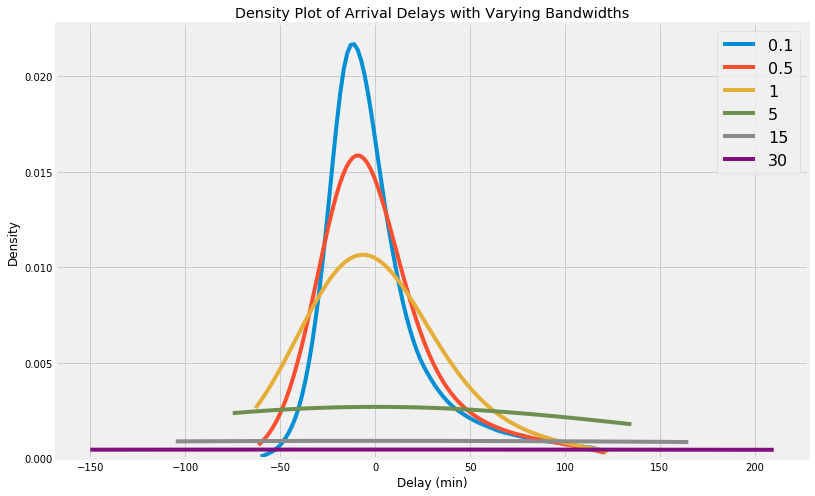

In [85]:
figsize(12, 8)
for bandwidth in [0.1, 0.5, 1, 5, 15, 30]:
    sns.distplot(flights['arr_delay'], hist = False, kde = True, kde_kws={'bw': bandwidth},
                 label = bandwidth)
    
plt.legend(prop={'size': 16})
plt.title('Density Plot of Arrival Delays with Varying Bandwidths'); plt.xlabel('Delay (min)'); plt.ylabel('Density');

## Find Top Five Carriers by Number of Flights

In [86]:
carrier_flights = pd.Series(flights.groupby('carrier')['year'].count()).sort_values(ascending=False)

In [87]:
top_five = carrier_flights.index[:5]

# Histogram with Top Five

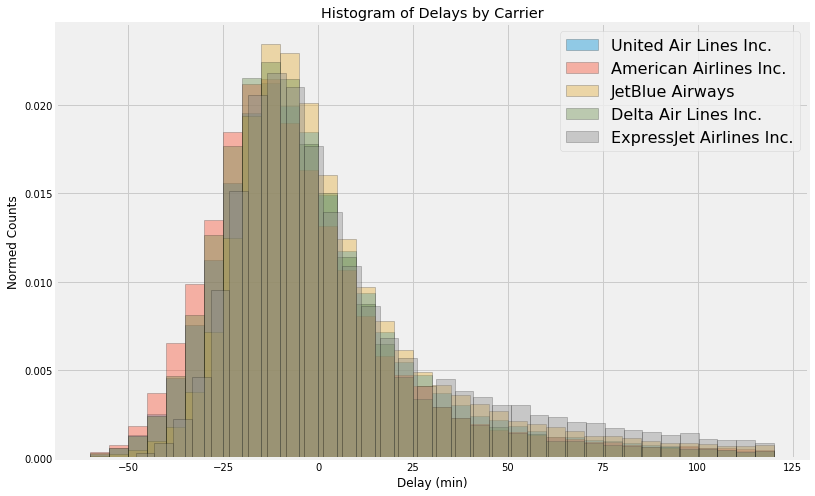

In [89]:
top_five_flights = flights[flights['carrier'].isin(top_five)]
figsize(12, 8)

for airline in top_five_flights['name'].unique():
    subset = top_five_flights[top_five_flights['name'] == airline]
    sns.distplot(subset['arr_delay'], bins = int(180/5), label = airline, 
                 hist = True, kde = False, norm_hist=True, hist_kws = {'edgecolor': 'black'})
    
plt.legend(prop={'size': 16})
plt.title('Histogram of Delays by Carrier'); plt.xlabel('Delay (min)'); plt.ylabel('Normed Counts');

# Density Plot of Delays by Carrier

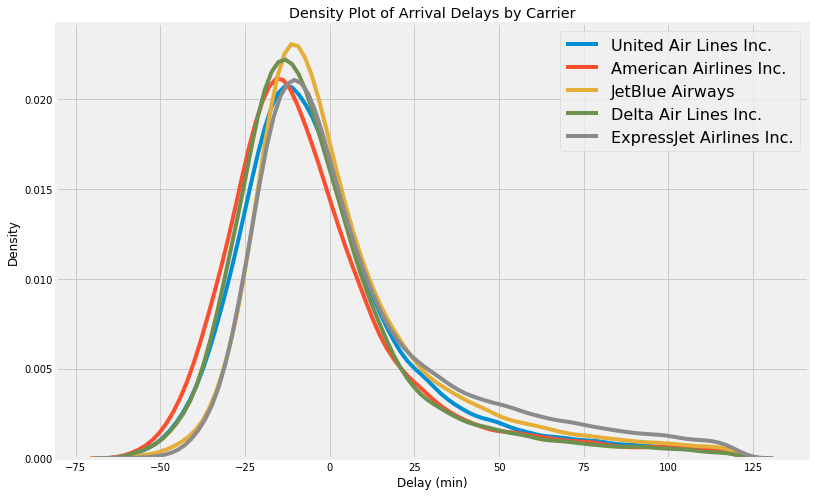

In [91]:
figsize(12, 8)
for airline in top_five_flights['name'].unique():
    subset = top_five_flights[top_five_flights['name'] == airline]
    sns.distplot(subset['arr_delay'], bins = int(180/5), hist = False, kde = True,
                 label = airline, hist_kws = {'edgecolor': 'black'})
    
plt.legend(prop={'size': 16})
plt.title('Density Plot of Arrival Delays by Carrier'); plt.xlabel('Delay (min)'); plt.ylabel('Density');

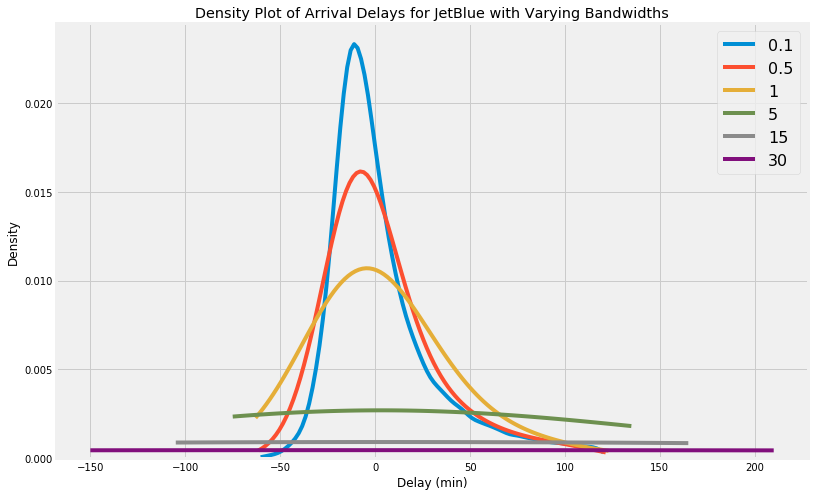

In [92]:
figsize(12, 8)
for bandwidth in [0.1, 0.5, 1, 5, 15, 30]:
    subset = top_five_flights[top_five_flights['name'] == 'JetBlue Airways']
    sns.distplot(subset['arr_delay'], hist = False, kde = True, kde_kws={'bw': bandwidth},
                 label = bandwidth)
    
plt.legend(prop={'size': 16})
plt.title('Density Plot of Arrival Delays for JetBlue with Varying Bandwidths'); plt.xlabel('Delay (min)'); plt.ylabel('Density');

# Density Plots in Bokeh

## Original Histogram

In [102]:
available_carriers = list(flights['name'].unique())
airline_colors = list(carriers['color'].unique())

In [94]:
def modify_doc(doc):
    
    def make_dataset(carrier_list, range_start = -60, range_end = 120, bin_width = 5):

        by_carrier = pd.DataFrame(columns=['proportion', 'left', 'right', 
                                           'f_proportion', 'f_interval',
                                           'name', 'color'])
        range_extent = range_end - range_start

        # Iterate through all the carriers
        for i, carrier_name in enumerate(carrier_list):

            # Subset to the carrier
            subset = flights[flights['name'] == carrier_name]

            # Create a histogram with 5 minute bins
            arr_hist, edges = np.histogram(subset['arr_delay'], 
                                           bins = int(range_extent / bin_width), 
                                           range = [range_start, range_end])

            # Divide the counts by the total to get a proportion
            arr_df = pd.DataFrame({'proportion': arr_hist / np.sum(arr_hist), 'left': edges[:-1], 'right': edges[1:] })

            # Format the proportion 
            arr_df['f_proportion'] = ['%0.5f' % proportion for proportion in arr_df['proportion']]

            # Format the interval
            arr_df['f_interval'] = ['%d to %d minutes' % (left, right) for left, right in zip(arr_df['left'], arr_df['right'])]

            # Assign the carrier for labels
            arr_df['name'] = carrier_name

            # Color each carrier differently
            arr_df['color'] = Category20_16[i]

            # Add to the overall dataframe
            by_carrier = by_carrier.append(arr_df)

        # Overall dataframe
        by_carrier = by_carrier.sort_values(['name', 'left'])

        return ColumnDataSource(by_carrier)
    
    def style(p):
        # Title 
        p.title.align = 'center'
        p.title.text_font_size = '20pt'
        p.title.text_font = 'serif'

        # Axis titles
        p.xaxis.axis_label_text_font_size = '14pt'
        p.xaxis.axis_label_text_font_style = 'bold'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_style = 'bold'

        # Tick labels
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'

        return p
    
    def make_plot(src):
        # Blank plot with correct labels
        p = figure(plot_width = 700, plot_height = 700, 
                  title = 'Histogram of Arrival Delays by Carrier',
                  x_axis_label = 'Delay (min)', y_axis_label = 'Proportion')

        # Quad glyphs to create a histogram
        p.quad(source = src, bottom = 0, top = 'proportion', left = 'left', right = 'right',
               color = 'color', fill_alpha = 0.7, hover_fill_color = 'color', legend = 'name',
               hover_fill_alpha = 1.0, line_color = 'black')

        # Hover tool with vline mode
        hover = HoverTool(tooltips=[('Carrier', '@name'), 
                                    ('Delay', '@f_interval'),
                                    ('Proportion', '@f_proportion')],
                          mode='vline')

        p.add_tools(hover)

        # Styling
        p = style(p)

        return p
    
    def update(attr, old, new):
        carriers_to_plot = [carrier_selection.labels[i] for i in carrier_selection.active]
        
        new_src = make_dataset(carriers_to_plot,
                               range_start = range_select.value[0],
                               range_end = range_select.value[1],
                               bin_width = binwidth_select.value)

        src.data.update(new_src.data)

        
    carrier_selection = CheckboxGroup(labels=available_carriers, active = [0, 1])
    carrier_selection.on_change('active', update)
    
    binwidth_select = Slider(start = 1, end = 30, 
                         step = 1, value = 5,
                         title = 'Delay Width (min)')
    binwidth_select.on_change('value', update)
    
    range_select = RangeSlider(start = -60, end = 180, value = (-60, 120),
                               step = 5, title = 'Delay Range (min)')
    range_select.on_change('value', update)
    
    
    
    initial_carriers = [carrier_selection.labels[i] for i in carrier_selection.active]
    
    src = make_dataset(initial_carriers,
                      range_start = range_select.value[0],
                      range_end = range_select.value[1],
                      bin_width = binwidth_select.value)
    
    p = make_plot(src)
    
    # Put controls in a single element
    controls = WidgetBox(carrier_selection, binwidth_select, range_select)
    
    # Create a row layout
    layout = row(controls, p)
    
    # Make a tab with the layout 
    tab = Panel(child=layout, title = 'Delay Histogram')
    tabs = Tabs(tabs=[tab])
    
    doc.add_root(tabs)
    
# Set up an application
handler = FunctionHandler(modify_doc)
app = Application(handler)

In [95]:
show(app)

In [69]:
from scipy.stats import gaussian_kde

In [96]:
carrier_list = top_five_flights['name'].unique()

In [133]:
def make_kde_dataset(carrier_list, range_start, range_end, bandwidth=None):
    xs = []
    ys = []
    colors = []
    labels = []
    
    for i, carrier in enumerate(carrier_list):
        subset = flights[flights['name'] == carrier]
        subset = subset[subset['arr_delay'].between(range_start, range_end)]
        
        kde = gaussian_kde(subset['arr_delay'], bw_method=bandwidth)
        # Evenly space x values
        x = np.linspace(range_start, range_end, 100)
        # Evaluate pdf at every value of x
        y = kde.pdf(x)
        
        # Append the values to plot
        xs.append(list(x))
        ys.append(list(y))
        
        # Append the colors and label
        colors.append(airline_colors[i])
        labels.append(carrier)
        
    kernel_source = ColumnDataSource(data={'x': xs, 'y': ys, 'color': colors, 'label': labels})
    return kernel_source

In [134]:
kde_src = make_kde_dataset(carrier_list, range_start=-60, range_end=120)

In [135]:
p = figure(plot_width = 500, plot_height = 500, title = 'Density Plots of Airline Delays',
          x_axis_label = 'Delay (min)', y_axis_label = 'Density')

p.multi_line('x', 'y', color = 'color', legend = 'label', line_width = 3, source = kde_src)
show(p)

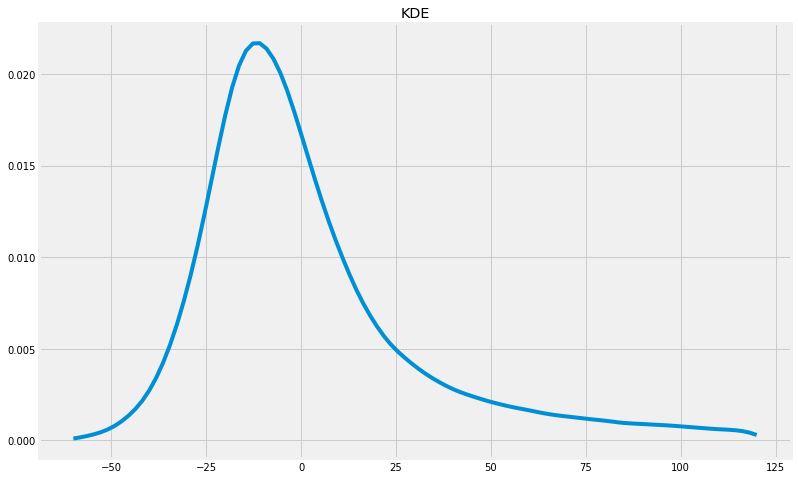

In [79]:
plt.plot(x, y); plt.title('KDE');

# Add Density Plot to Completed Application

In [139]:
def modify_doc(doc):
    
    def make_dataset(carrier_list, range_start = -60, range_end = 120, bin_width = 5):

        by_carrier = pd.DataFrame(columns=['proportion', 'left', 'right', 
                                           'f_proportion', 'f_interval',
                                           'name', 'color'])
        range_extent = range_end - range_start

        # Iterate through all the carriers
        for i, carrier_name in enumerate(carrier_list):

            # Subset to the carrier
            subset = flights[flights['name'] == carrier_name]

            # Create a histogram with 5 minute bins
            arr_hist, edges = np.histogram(subset['arr_delay'], 
                                           bins = int(range_extent / bin_width), 
                                           range = [range_start, range_end])

            # Divide the counts by the total to get a proportion
            arr_df = pd.DataFrame({'proportion': arr_hist / np.sum(arr_hist), 'left': edges[:-1], 'right': edges[1:] })

            # Format the proportion 
            arr_df['f_proportion'] = ['%0.5f' % proportion for proportion in arr_df['proportion']]

            # Format the interval
            arr_df['f_interval'] = ['%d to %d minutes' % (left, right) for left, right in zip(arr_df['left'], arr_df['right'])]

            # Assign the carrier for labels
            arr_df['name'] = carrier_name

            # Color each carrier differently
            arr_df['color'] = Category20_16[i]

            # Add to the overall dataframe
            by_carrier = by_carrier.append(arr_df)

        # Overall dataframe
        by_carrier = by_carrier.sort_values(['name', 'left'])

        return ColumnDataSource(by_carrier)
    
    
    def make_kde_dataset(carrier_list, range_start, range_end, bandwidth):
        
        xs = []
        ys = []
        colors = []
        labels = []

        for i, carrier in enumerate(carrier_list):
            subset = flights[flights['name'] == carrier]
            subset = subset[subset['arr_delay'].between(range_start, range_end)]

            kde = gaussian_kde(subset['arr_delay'], bw_method=bandwidth)
            # Evenly space x values
            x = np.linspace(range_start, range_end, 100)
            # Evaluate pdf at every value of x
            y = kde.pdf(x)

            # Append the values to plot
            xs.append(list(x))
            ys.append(list(y))

            # Append the colors and label
            colors.append(airline_colors[i])
            labels.append(carrier)

        kernel_source = ColumnDataSource(data={'x': xs, 'y': ys, 'color': colors, 'label': labels})
        
        return kernel_source
    
    def style(p):
        # Title 
        p.title.align = 'center'
        p.title.text_font_size = '20pt'
        p.title.text_font = 'serif'

        # Axis titles
        p.xaxis.axis_label_text_font_size = '14pt'
        p.xaxis.axis_label_text_font_style = 'bold'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_style = 'bold'

        # Tick labels
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'

        return p
    
    def make_plot(src):
        # Blank plot with correct labels
        p = figure(plot_width = 700, plot_height = 700, 
                  title = 'Histogram of Arrival Delays by Carrier',
                  x_axis_label = 'Delay (min)', y_axis_label = 'Proportion')

        # Quad glyphs to create a histogram
        p.quad(source = src, bottom = 0, top = 'proportion', left = 'left', right = 'right',
               color = 'color', fill_alpha = 0.7, hover_fill_color = 'color', legend = 'name',
               hover_fill_alpha = 1.0, line_color = 'black')

        # Hover tool with vline mode
        hover = HoverTool(tooltips=[('Carrier', '@name'), 
                                    ('Delay', '@f_interval'),
                                    ('Proportion', '@f_proportion')],
                          mode='vline')

        p.add_tools(hover)

        # Styling
        p = style(p)

        return p
    
    def make_kde_plot(kde_src):
        p = figure(plot_width = 700, plot_height = 700,
                   title = 'Density Plot of Arrival Delays by Carrier',
                   x_axis_label = 'Delay (min)', y_axis_label = 'Density')
        
        
        p.multi_line('x', 'y', color = 'color', legend = 'label', 
                     line_width = 3,
                     source = kde_src)
        
        # Hover tool with next line policy
        hover = HoverTool(tooltips=[('Carrier', '@label'), 
                                    ('Delay', '$x'),
                                    ('Density', '$y')],
                          line_policy = 'next')
        
        # Add the hover tool and styling
        p.add_tools(hover)
        
        p = style(p)
        
        return p
    
    def update(attr, old, new):
        carriers_to_plot = [carrier_selection.labels[i] for i in carrier_selection.active]
        
        new_src = make_dataset(carriers_to_plot,
                               range_start = range_select.value[0],
                               range_end = range_select.value[1],
                               bin_width = binwidth_select.value)
        
        if bandwidth_choose.active == []:
            bandwidth = None
        else:
            bandwidth = bandwidth_select.value
            
        new_kde_src = make_kde_dataset(carriers_to_plot,
                                       range_start = range_select.value[0],
                                       range_end = range_select.value[1],
                                       bandwidth = bandwidth)

        src.data.update(new_src.data)
        kde_src.data.update(new_kde_src.data)
        
        
    carrier_selection = CheckboxGroup(labels=available_carriers, active = [0, 1])
    carrier_selection.on_change('active', update)
    
    binwidth_select = Slider(start = 1, end = 30, 
                         step = 1, value = 5,
                         title = 'Delay Width (min)')
    binwidth_select.on_change('value', update)
    
    range_select = RangeSlider(start = -60, end = 180, value = (-60, 120),
                               step = 5, title = 'Delay Range (min)')
    range_select.on_change('value', update)
    
    
    bandwidth_select = Slider(start = 0.1, end = 5, 
                         step = 0.1, value = 0.5,
                         title = 'Bandwidth for Density Plot')
    bandwidth_select.on_change('value', update)
    
    bandwidth_choose = CheckboxButtonGroup(labels=['Choose Bandwidth (Auto)'], active = [])
    bandwidth_choose.on_change('active', update)

    initial_carriers = [carrier_selection.labels[i] for i in carrier_selection.active]
    
    src = make_dataset(initial_carriers,
                      range_start = range_select.value[0],
                      range_end = range_select.value[1],
                      bin_width = binwidth_select.value)
    
    kde_src = make_kde_dataset(initial_carriers, 
                               range_start = range_select.value[0],
                               range_end = range_select.value[1],
                               bandwidth = bandwidth_select.value) 
    
    p = make_plot(src)
    kde_p = make_kde_plot(kde_src)
    
    # Put controls in a single element
    controls = WidgetBox(carrier_selection, binwidth_select, range_select, 
                         bandwidth_select, bandwidth_choose)
    
    # Create a row layout
    layout = row(controls, p, kde_p)
    
    # Make a tab with the layout 
    tab = Panel(child=layout, title = 'Histogram and Density Plots')
    tabs = Tabs(tabs=[tab])
    
    doc.add_root(tabs)
    
# Set up an application
handler = FunctionHandler(modify_doc)
app = Application(handler)

In [140]:
show(app)